In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
from matplotlib import colormaps
import numpy as np
from sklearn.pipeline import Pipeline
import random

In [2]:
training_file = "wildfires_training.csv"
test_file = "wildfires_test.csv"

df = pd.read_csv("wildfires_training.csv")
df_test = pd.read_csv("wildfires_test.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fire           154 non-null    object 
 1   year           154 non-null    int64  
 2   temp           154 non-null    int64  
 3   humidity       154 non-null    int64  
 4   rainfall       154 non-null    float64
 5   drought_code   154 non-null    float64
 6   buildup_index  154 non-null    float64
 7   day            154 non-null    int64  
 8   month          154 non-null    int64  
 9   wind_speed     154 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 12.2+ KB


In [4]:
df.describe()

,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,2012.058442,31.545455,63.071429,0.855844,48.146299,16.285065,15.077922,7.603896,16.383117
std,3.355294,3.952481,16.038804,2.246798,47.348331,14.346991,8.085760,1.217620,3.218001
min,2007.000000,22.000000,21.000000,0.000000,7.180000,1.320000,1.000000,6.000000,6.000000
25%,2009.000000,29.000000,52.000000,0.000000,9.720000,5.797500,9.000000,6.000000,14.000000
50%,2012.000000,31.000000,64.000000,0.000000,31.330000,11.450000,15.000000,8.000000,16.000000
75%,2015.000000,34.000000,77.000000,0.600000,65.257500,22.775000,21.000000,9.000000,18.750000
max,2017.000000,43.000000,92.000000,16.800000,221.350000,67.720000,31.000000,9.000000,30.000000


In [5]:
df.shape

(154, 10)

## Pre-Processing

In [6]:
# Interaction Months
df["temp_humidity"] = df["temp"] * df["humidity"]
df["wind_bui"] = df["wind_speed"] * df["buildup_index"]

df_test["temp_humidity"] = df_test["temp"] * df_test["humidity"]
df_test["wind_bui"] = df_test["wind_speed"] * df_test["buildup_index"]

In [7]:
dependent_variable = "fire"
independent_variables = [col for col in df.columns if col != dependent_variable]

In [8]:
# Training predictors and response variables
X_training = df[independent_variables]
y_training = df[dependent_variable] == "yes"

In [9]:
X_test = df_test[independent_variables]
y_test = df_test[dependent_variable] == "yes"

In [10]:
# Time to re-run with Hyper-parameter tuning
penalties = ["l1", "l2", "elasticnet", None]
c_values = np.logspace(-3, 3, 100)

In [11]:
training_test_comparison = {}

for penalty in penalties:
    models_info = []
    for c in c_values:
        l1_ratio = 0.3 if penalty == "elasticnet" else None

        if penalty == "l1":
            solver = "liblinear"
        elif penalty == "elasticnet":
            solver = "saga"
        else:
            solver = "lbfgs"

        logreg_pipe = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "logreg",
                    LogisticRegression(
                        random_state=42,
                        penalty=penalty,
                        solver=solver,
                        max_iter=5000,
                        C=c if penalty is not None else 1.0,
                        l1_ratio=l1_ratio,
                    ),
                ),
            ]
        )

        logreg_pipe.fit(X_training, y_training)
        predictions_training = logreg_pipe.predict(X_training)
        predictions_test = logreg_pipe.predict(X_test)

        accuracy_training = metrics.accuracy_score(y_training, predictions_training)
        accuracy_test = metrics.accuracy_score(y_test, predictions_test)

        y_probs = logreg_pipe.predict_proba(X_test)[:, 1]

        models_info.append(
            {
                "C": c,
                "training_accuracy": accuracy_training,
                "test_accuracy": accuracy_test,
                "coefficients": logreg_pipe.named_steps["logreg"].coef_,
                "intercept": logreg_pipe.named_steps["logreg"].intercept_,
                "pipeline": logreg_pipe,
                "predictions_test": predictions_test,
            }
        )

    # Save all models for this penalty
    training_test_comparison[penalty] = models_info

In [12]:
# Print nicely
for pen in penalties:
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    print(f"Best {pen} model:")
    print(f"  C = {best_model['C']}")
    print(f"  Training Accuracy = {best_model['training_accuracy']:.4f}")
    print(f"  Test Accuracy = {best_model['test_accuracy']:.4f}")
    print(f"  Coefficients = {best_model['coefficients']}")
    print(f"  Intercept = {best_model['intercept']}\n")

Best l1 model:
  C = 8.697490026177835
  Training Accuracy = 0.9416
  Test Accuracy = 0.9200
  Coefficients = [[  0.30861928   1.89185419   1.73283285 -30.98701068   0.
    0.          -0.49753925   0.21319973  -0.40585903  -2.39914192
    4.46277264]]
  Intercept = [-9.00719446]

Best l2 model:
  C = 17.47528400007683
  Training Accuracy = 0.9156
  Test Accuracy = 0.9400
  Coefficients = [[  0.14283778   1.30242127   1.54285929 -10.51785438  -1.71606556
    1.739847    -0.5104233    0.22074675  -0.44674296  -1.87749636
    3.23502585]]
  Intercept = [-2.21142958]

Best elasticnet model:
  C = 13.219411484660288
  Training Accuracy = 0.9156
  Test Accuracy = 0.9400
  Coefficients = [[  0.13937616   1.12645922   1.21127038 -10.39584491  -1.68902658
    1.83902084  -0.51330045   0.22019413  -0.42644092  -1.60158249
    3.08606607]]
  Intercept = [-2.1950106]

Best None model:
  C = 0.001
  Training Accuracy = 0.9351
  Test Accuracy = 0.8800
  Coefficients = [[ 8.90979593e-01  1.82530368e

## Comparison Graphs
Below are graphs showing the effect of penalty functions and C Values (Lambda Inverse) on Logistic Regression

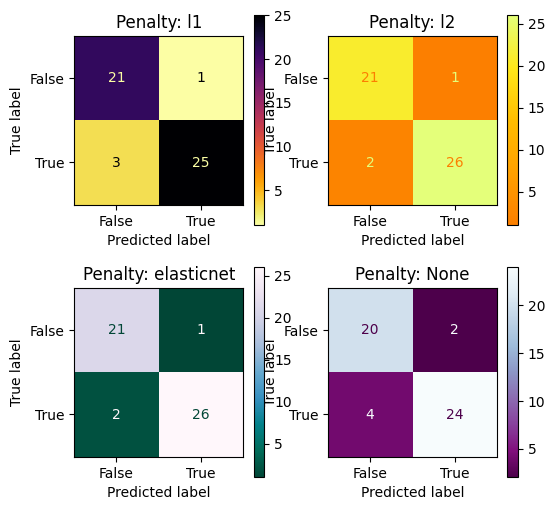

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
ax = ax.flatten()

for i, pen in enumerate(["l1", "l2", "elasticnet", None]):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])

    cm = confusion_matrix(y_test, best_model["predictions_test"])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=logreg_pipe.classes_
    )

    disp.plot(cmap=random.choice(list(colormaps)), ax=ax[i])
    disp.ax_.set_title(f"Penalty: {pen}")

In [14]:
l1 = training_test_comparison["l1"]
accuracy_training_l1 = [el["training_accuracy"] for el in l1]
accuracy_test_l1 = [el["test_accuracy"] for el in l1]

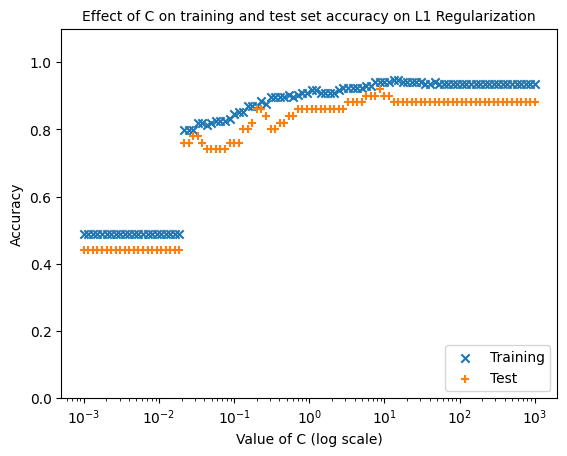

In [15]:
plt.scatter(c_values, accuracy_training_l1, marker="x")
plt.scatter(c_values, accuracy_test_l1, marker="+")
plt.xscale("log")  # use log scale for C
plt.ylim([0.0, 1.1])
plt.xlabel("Value of C (log scale)")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title(
    "Effect of C on training and test set accuracy on L1 Regularization", fontsize=10
)
plt.show()

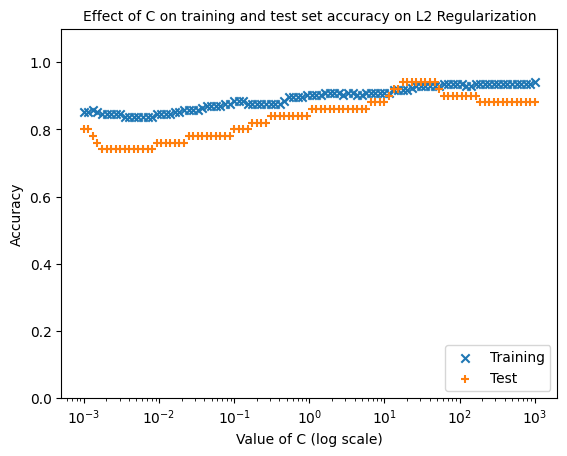

In [16]:
l2 = training_test_comparison["l2"]
accuracy_training_l2 = [el["training_accuracy"] for el in l2]
accuracy_test_l2 = [el["test_accuracy"] for el in l2]

plt.scatter(c_values, accuracy_training_l2, marker="x")
plt.scatter(c_values, accuracy_test_l2, marker="+")
plt.xscale("log")  # use log scale for C
plt.ylim([0.0, 1.1])
plt.xlabel("Value of C (log scale)")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title(
    "Effect of C on training and test set accuracy on L2 Regularization", fontsize=10
)
plt.show()

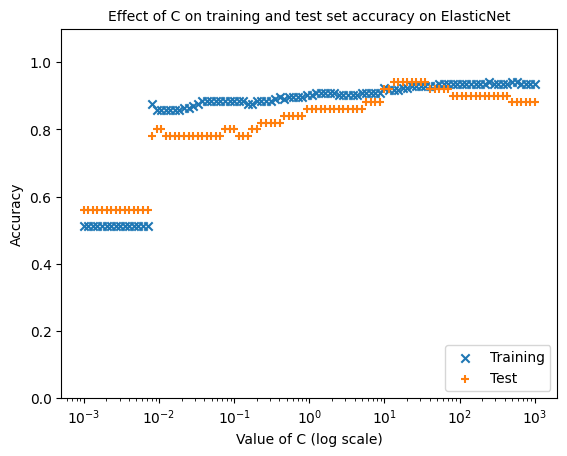

In [17]:
elasticnet = training_test_comparison["elasticnet"]
accuracy_training_elasticnet = [el["training_accuracy"] for el in elasticnet]
accuracy_test_elasticnet = [el["test_accuracy"] for el in elasticnet]

plt.scatter(c_values, accuracy_training_elasticnet, marker="x")
plt.scatter(c_values, accuracy_test_elasticnet, marker="+")
plt.xscale("log")  # use log scale for C
plt.ylim([0.0, 1.1])
plt.xlabel("Value of C (log scale)")
plt.ylabel("Accuracy")
plt.legend(["Training", "Test"], loc=4)
plt.title("Effect of C on training and test set accuracy on ElasticNet", fontsize=10)
plt.show()

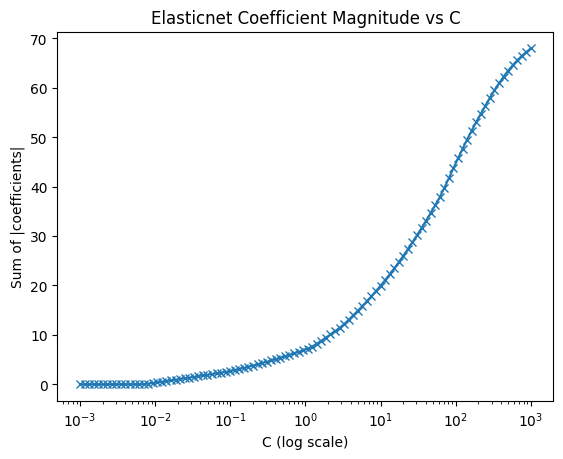

In [18]:
coef_norms_elasticnet = [np.sum(np.abs(el["coefficients"])) for el in elasticnet]
plt.plot(c_values, coef_norms_elasticnet, marker="x")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Sum of |coefficients|")
plt.title("Elasticnet Coefficient Magnitude vs C")
plt.show()

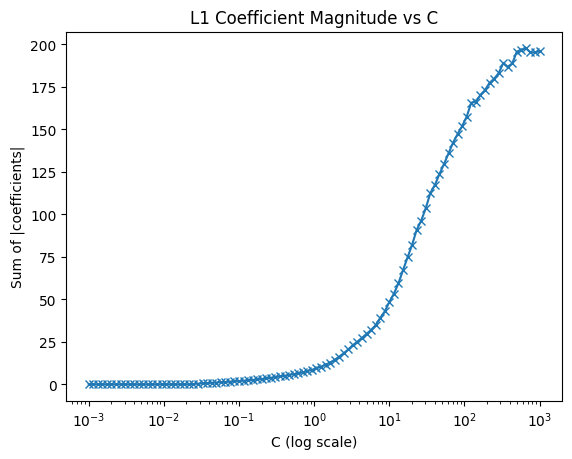

In [19]:
coef_norms_l1 = [np.sum(np.abs(el["coefficients"])) for el in l1]
plt.plot(c_values, coef_norms_l1, marker="x")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Sum of |coefficients|")
plt.title("L1 Coefficient Magnitude vs C")
plt.show()

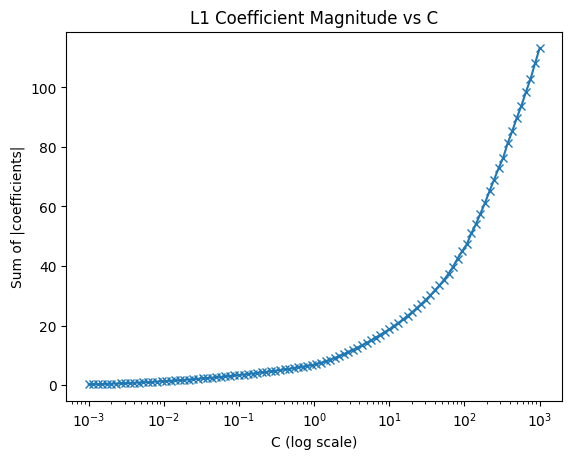

In [20]:
coef_norms_l2 = [np.sum(np.abs(el["coefficients"])) for el in l2]
plt.plot(c_values, coef_norms_l2, marker="x")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Sum of |coefficients|")
plt.title("L1 Coefficient Magnitude vs C")
plt.show()

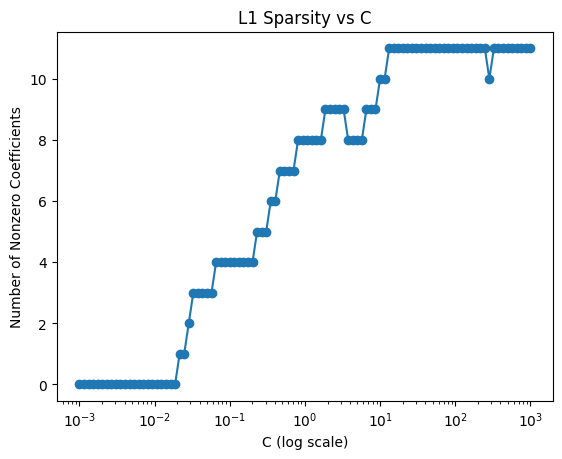

In [21]:
num_nonzero_l1 = [np.count_nonzero(el["coefficients"]) for el in l1]
plt.plot(c_values, num_nonzero_l1, marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("L1 Sparsity vs C")
plt.show()

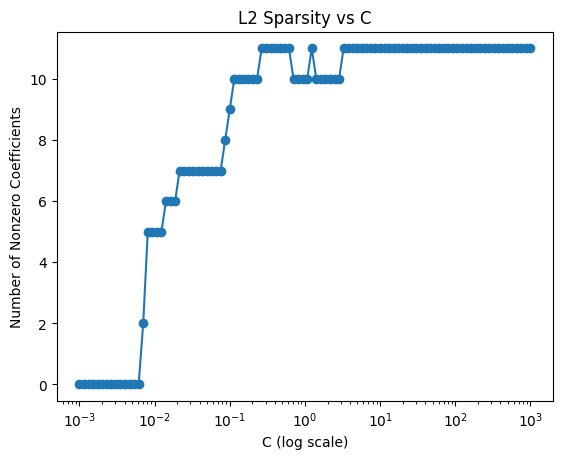

In [22]:
num_nonzero_elasticnet = [np.count_nonzero(el["coefficients"]) for el in elasticnet]
plt.plot(c_values, num_nonzero_elasticnet, marker="o")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Number of Nonzero Coefficients")
plt.title("L2 Sparsity vs C")
plt.show()

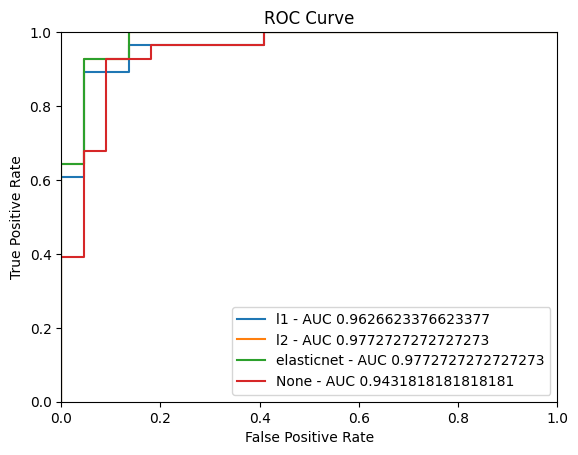

In [23]:
for i, pen in enumerate(["l1", "l2", "elasticnet", None]):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    y_probs = best_model["pipeline"].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{pen} - AUC {auc(fpr, tpr)}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title("ROC Curve")

In [44]:
for i, pen in enumerate(["l1", "l2", "elasticnet", None]):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    title = f"\n\t\t\t\t\t{pen.upper() if type(pen) == str else "No Regularization"} Classification"
    print(f'{title}\n{classification_report(y_test, best_model["predictions_test"])}')


					L1 Classification
              precision    recall  f1-score   support

       False       0.88      0.95      0.91        22
        True       0.96      0.89      0.93        28

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50


					L2 Classification
              precision    recall  f1-score   support

       False       0.91      0.95      0.93        22
        True       0.96      0.93      0.95        28

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50


					ELASTICNET Classification
              precision    recall  f1-score   support

       False       0.91      0.95      0.93        22
        True       0.96      0.93      0.95        28

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94     